In [1]:
import pandas as pd
import numpy as np
import folium
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from folium.features import DivIcon
matplotlib.style.use('ggplot')

In [2]:
vancouver_geojson = r'local-area-boundary.geojson'

In [3]:
with open(vancouver_geojson) as f:
    data = json.load(f)
neighbourhood_list = []
lat = []
lng = []
for i in data['features']:
    neighbourhood_list.append(i['properties']['name'])
    lat.append(i['properties']['geo_point_2d'][0])
    lng.append(i['properties']['geo_point_2d'][1])

In [4]:
df = pd.DataFrame({'Neighbourhood': neighbourhood_list, 'Latitude': lat, 'Longitude': lng})
df.head()

,Neighbourhood,Latitude,Longitude
0,Dunbar-Southlands,49.237962,-123.189547
1,Kerrisdale,49.223655,-123.159576
2,Killarney,49.217022,-123.037647
3,Kitsilano,49.267540,-123.163295
4,South Cambie,49.245556,-123.121801
5,Victoria-Fraserview,49.220012,-123.064135
6,Kensington-Cedar Cottage,49.246686,-123.072885
7,Mount Pleasant,49.263065,-123.098513
8,Oakridge,49.226403,-123.123025
9,Renfrew-Collingwood,49.247343,-123.040166


In [5]:
# create map
neighbourhood_map = folium.Map(location=[49.24, -123.11], zoom_start=12)
folium.GeoJson(
    vancouver_geojson,
    name='geojson'
).add_to(neighbourhood_map)
# add markers to the map
markers_colors = []
for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(str(poi))
    folium.Marker(
        [lat, lon],
        popup=label).add_to(neighbourhood_map)
neighbourhood_map

In [6]:
# Foursquare info
CLIENT_ID = 'CDSEIX1KTMHBQ0QNCTW2VLUWMKI2JFJS2MOD1ZDZ401DZG54'
CLIENT_SECRET = 'MNLXZW1HWOPLEOO4TLUSN4SBVDPL3OHEDZ2TOZIFJVNJTQQG'
VERSION = '20191231'

In [7]:
def getNearbyVenues(neighbourhoods, latitudes, longitudes, radius, LIMIT):
    venues_list=[]
    for pc, lat, lng in zip(neighbourhoods, latitudes, longitudes):    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&openNow=0&sortByDistance=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            LIMIT)     
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
                pc, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except KeyError:
            # return only relevant information for each nearby venue
            venues_list.append([
                pc, 
                lat, 
                lng, 
                np.nan, 
                np.nan, 
                np.nan,  
                np.nan])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
df_venue = getNearbyVenues(df['Neighbourhood'],
                           df['Latitude'],
                           df['Longitude'],
                           radius=1250,
                           LIMIT=50
                           )
df_venue.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dunbar-Southlands,49.237962,-123.189547,H-Mart,49.235813,-123.185640,Grocery Store
1,Dunbar-Southlands,49.237962,-123.189547,Blaq Sheep Coffee House And Bistro,49.235501,-123.185324,Coffee Shop
2,Dunbar-Southlands,49.237962,-123.189547,Celtic Treasure Chest,49.235169,-123.185504,Grocery Store
3,Dunbar-Southlands,49.237962,-123.189547,New District Store,49.234880,-123.185230,Liquor Store
4,Dunbar-Southlands,49.237962,-123.189547,Red Tuna,49.234746,-123.184952,Japanese Restaurant


In [12]:
df_venue['Venue Category'].replace('Sushi Restaurant', 'Japanese Restaurant', inplace=True)
df_venue['Venue Category'].replace('Coffee Shop', 'Café', inplace=True)
df_venue['Venue Category'].replace('Gym', 'Gym / Fitness Center', inplace=True)
df_venue['Venue Category'].replace('Neighborhood', 'Chinatown', inplace=True)
df_venue['Venue Category'].replace('Pizza', 'Pizza Place', inplace=True)
df_venue = df_venue[df_venue['Venue Category'] != 'Restaurant']

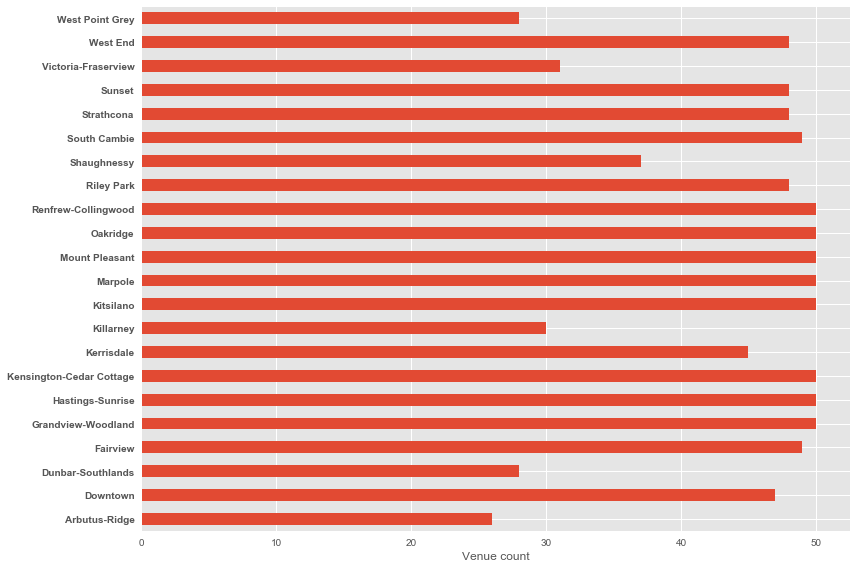

In [13]:
fig, ax = plt.subplots()
venue_per_neighbourhood = df_venue.groupby('Neighbourhood')['Venue'].size().reset_index(name='Count')
venue_per_neighbourhood.plot.barh(ax=ax, figsize=(12, 8))
ax.set_xlabel('Venue count')
fontproperties = {'weight' : 'bold'}
ax.set_yticklabels(venue_per_neighbourhood['Neighbourhood'].tolist(), fontproperties)
ax.get_legend().remove()
fig.tight_layout()
plt.savefig('venue_counts.pdf', bbox_inches='tight')

In [14]:
neighbourhoods_need_data = ['Arbutus-Ridge', 'Killarney', 'Victoria-Fraserview', 'Dunbar-Southlands', 'West Point Grey']
df_less_data = df_venue[df_venue['Neighbourhood'].isin(neighbourhoods_need_data)]

In [15]:
# create map
venue_map = folium.Map(location=[49.24, -123.11], zoom_start=12)
folium.GeoJson(
    vancouver_geojson,
    name='geojson'
).add_to(venue_map)
# add markers to the map
markers_colors = []
for lat, lon, poi in zip(df_less_data['Venue Latitude'], df_less_data['Venue Longitude'], df_less_data['Venue']):
    label = folium.Popup(str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='crimson',
        fill=True).add_to(venue_map)
temp = df[df['Neighbourhood'].isin(neighbourhoods_need_data)]
for lat, lon, poi in zip(temp['Latitude'], temp['Longitude'], temp['Neighbourhood']):
    folium.Marker(
        [lat, lon],
        popup=poi).add_to(venue_map)
venue_map

In [16]:
# one hot encoding
df_onehot = pd.get_dummies(df_venue.set_index('Neighbourhood')[['Venue Category']], prefix="", prefix_sep="")

df_grouped = df_onehot.groupby('Neighbourhood').sum().reset_index()
df_grouped.head()

,Neighbourhood,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,...,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Wine Shop,Women's Store,Yoga Studio
0,Arbutus-Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Downtown,0,0,1,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,Dunbar-Southlands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fairview,1,0,0,2,2,0,0,2,0,...,0,0,0,0,0,1,1,0,0,0
4,Grandview-Woodland,0,0,0,0,2,1,0,1,0,...,1,0,0,2,0,0,0,0,0,0


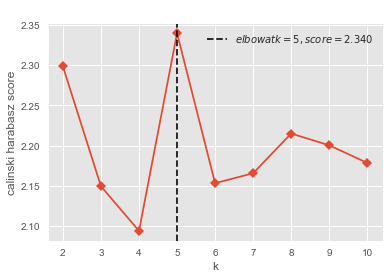

In [20]:
df_grouped_clustering = df_onehot.groupby('Neighbourhood').mean().reset_index().drop('Neighbourhood', axis=1)
# df_grouped_clustering = StandardScaler().fit_transform(df_grouped.drop('Neighbourhood', axis=1))
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,11), timings=False, metric='calinski_harabasz', title=' '
) #metric='calinski_harabasz', 
visualizer.fit(df_grouped_clustering)        # Fit the data to the visualizer
visualizer.show(outpath="elbow.pdf")

In [67]:
df_grouped = df_onehot.groupby('Neighbourhood').sum().reset_index()
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
# add clustering labels
df_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [68]:
df_merged = df.join(df_grouped.set_index('Neighbourhood'), on='Neighbourhood')
df_merged.dropna(axis=0, inplace=True)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# create map
cluster_map = folium.Map(location=[49.24, -123.11], zoom_start=12)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighbourhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(cluster_map)
    folium.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(0,0),
            icon_anchor=(-5,0),
            html=f'<div style="font-size: 10pt; font-weight: bold">{cluster}</div>',
            )).add_to(cluster_map)
# display map
cluster_map

In [23]:
til = 10
visualize_cluster = {}
for i in range(kclusters):
    visualize_cluster[i] = df_grouped.iloc[df_grouped.groupby('Cluster Labels').groups[i]].sum()[2:].sort_values(ascending=False)[:til].to_dict()

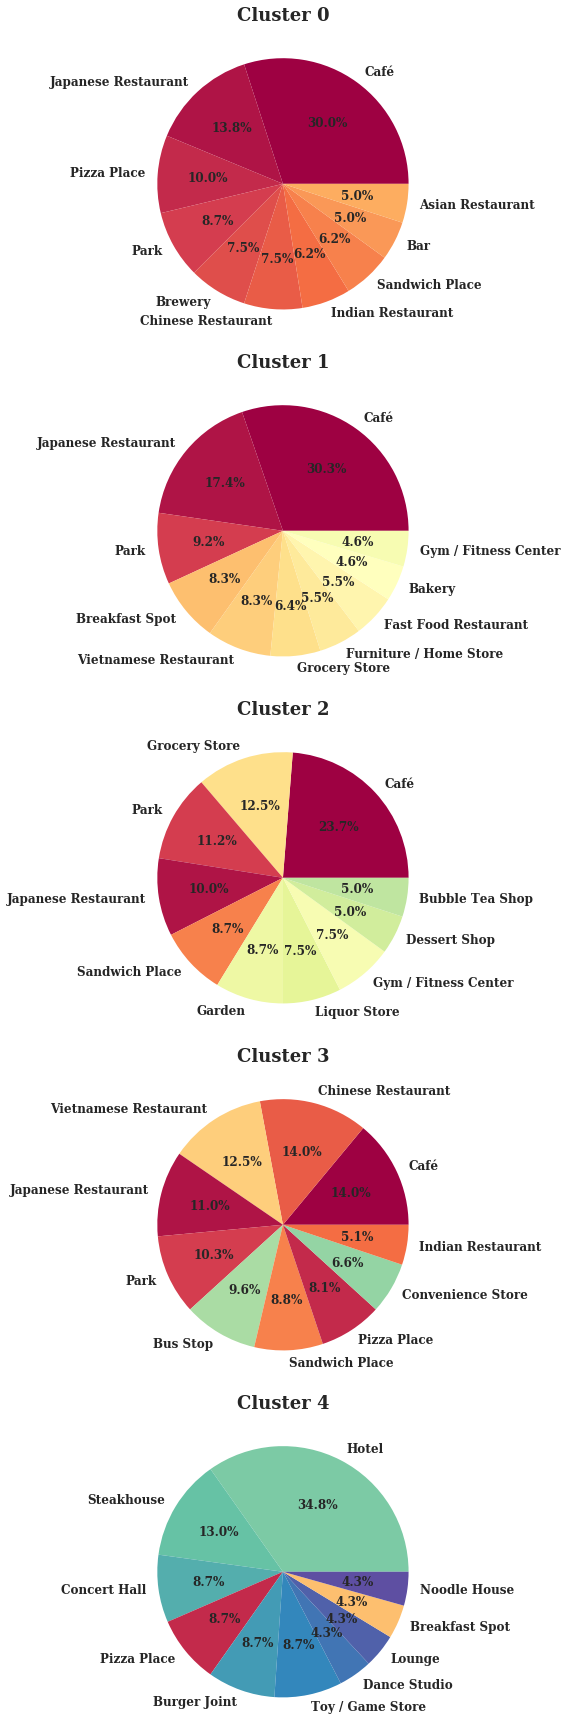

In [25]:
def trim_axs(axs, N):
    # massage the axs list to have correct length
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

rows = kclusters
cols = 1
figsize = (12, 24)
fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(visualize_cluster))

# get unique vanue categories to map colors
unique_venues = []
for i in range(len(visualize_cluster)):
    for key, value in visualize_cluster[i].items():
        if key not in unique_venues:
            unique_venues.append(key)

# map label to color
cmap = plt.cm.Spectral
spectral = cmap(np.linspace(0, 1., num=len(unique_venues)))

colordict = {}
for l,c in zip(unique_venues, spectral):
    colordict[l] = c

for ax, i in zip(axs, range(len(visualize_cluster))):
    ticks = []
    data = []
    for key, value in visualize_cluster[i].items():
        ticks.append(key)
        data.append(value)
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, labels=ticks, autopct=lambda pct: func(pct, data),
                                      textprops=dict(family='serif', size=12, fontweight='bold'))
    for wedge in wedges:
        wedge.set_facecolor(colordict[wedge.get_label()])
    
    # ax.legend(wedges, ticks,
    #         fontsize=12,
    #         title= 'Venue category',
    #         loc='center left',
    #         bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'Cluster {i}', fontdict={'family': 'serif', 'fontsize': 18, 'weight': 'bold', 'verticalalignment': 'baseline'})
plt.savefig('pie_cluster.pdf', bbox_inches='tight')

In [26]:
df_crime = pd.read_csv('crimedata_csv_all_years.csv')

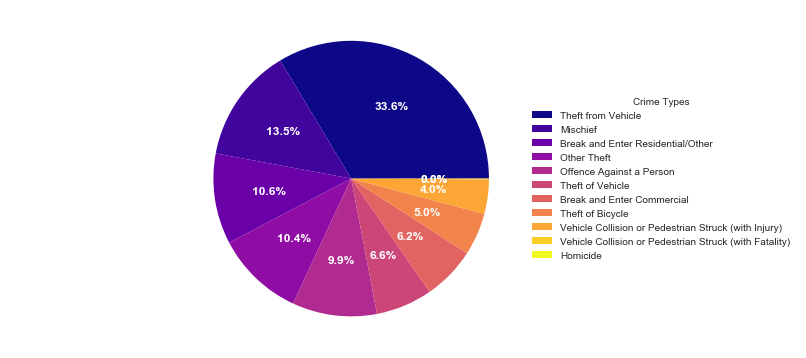

In [27]:
df_crime_counts = pd.DataFrame(df_crime['TYPE'].value_counts())
df_crime_counts.columns = ['Counts']
df_crime_counts.index.name = 'Type'
# set color scheme for the pie chart
x = np.arange(df_crime_counts.shape[0])
ys = [i + x + (i*x)**2 for i in range(df_crime_counts.shape[0])]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
plasma = [colors.rgb2hex(i) for i in colors_array]
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
df_crime_counts.plot.pie(y='Counts', figsize=(10.80,10.80), ax=ax, autopct='%1.1f%%', colors=plasma, textprops=dict(size=12, color='w', weight='bold'))
ax.set_axis_off()
ax.legend(title='Crime Types',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))
fig.tight_layout()
plt.savefig('pie.pdf', bbox_inches='tight')

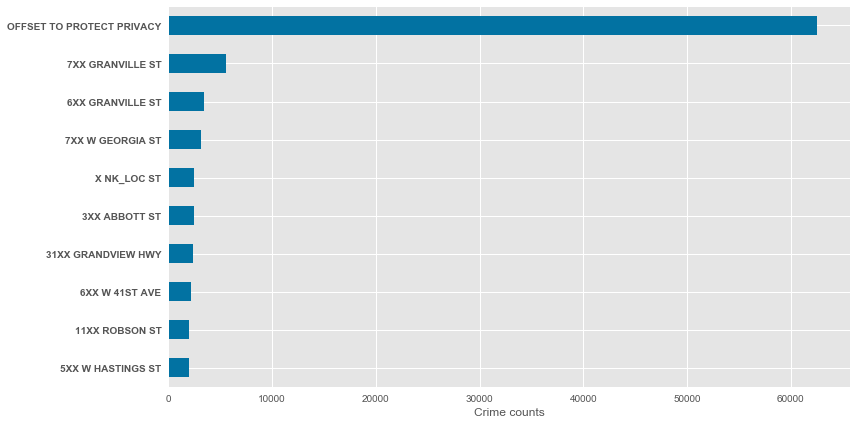

In [28]:
fig, ax = plt.subplots()
df_block_count = pd.DataFrame(df_crime["HUNDRED_BLOCK"].value_counts()[:10])
df_block_count.columns = ['Count']
df_block_count.sort_values(by='Count', ascending=True, inplace=True)
df_block_count.plot.barh(ax=ax, figsize=(12, 6), color='b')
ax.set_xlabel('Crime counts')
fontproperties = {'weight' : 'bold'}
ax.set_yticklabels(df_block_count.index.tolist(), fontproperties)
ax.get_legend().remove()
fig.tight_layout()
plt.savefig('block_counts.pdf', bbox_inches='tight')

In [29]:
df_crime = df_crime[df_crime['HUNDRED_BLOCK'] != 'OFFSET TO PROTECT PRIVACY']

In [30]:
import math

def utmToLatLong(utmEasting, utmNorthing, utmZone):
    eastingOffset = 500000.0
    northingOffset = 10000000.0
    k0 = 0.9996
    equatorialRadius = 6378137.0
    eccSquared = 0.006694380023
    eccPrimeSquared = eccSquared / (1 - eccSquared)
    e1 = (1 - math.sqrt(1 - eccSquared)) / (1 + math.sqrt(1 - eccSquared));
    rad2deg = 180.0/math.pi

    # Casts input from string to floats or ints
    # Removes 500,000 metre offset for longitude
    xUTM = float(utmEasting) - eastingOffset
    yUTM = float(utmNorthing)
    zoneNumber = int(utmZone)

    # Finds the origin longitude for the zone
    lonOrigin = (zoneNumber - 1) * 6 - 180 + 3 # +3 puts in zone centre

    M = yUTM / k0 #This finds the meridional arc
    mu = M / (equatorialRadius * (1- eccSquared / 4 - 3 * eccSquared * eccSquared / 64 -5 * eccSquared * eccSquared * eccSquared /256))

    # Calculates the footprint latitude
    phi1Rad = mu + (3 * e1 / 2 - 27 * e1 * e1 * e1 /32) * math.sin(2*mu) + ( 21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32) * math.sin( 4 * mu) + (151 * e1 * e1 * e1 / 96) * math.sin(6 * mu)
    phi1 = phi1Rad * rad2deg

    # Variables for conversion equations
    N1 = equatorialRadius / math.sqrt( 1 - eccSquared * math.sin(phi1Rad) *  math.sin(phi1Rad))
    T1 = math.tan(phi1Rad) * math.tan(phi1Rad)
    C1 = eccPrimeSquared * math.cos(phi1Rad) * math.cos(phi1Rad)
    R1 = equatorialRadius * (1 - eccSquared) / math.pow(1 - eccSquared * math.sin(phi1Rad) * math.sin(phi1Rad), 1.5)
    D = xUTM / (N1 * k0)

    # Calculate latitude, in decimal degrees
    lat = phi1Rad - ( N1 * math.tan(phi1Rad) / R1) * (D * D / 2 - (5 + 3 * T1 + 10 * C1 - 4 * C1 * C1 - 9 * eccPrimeSquared) * D * D * D * D / 24 + (61 + 90 * T1 + 298 * C1 + 45 * T1 * T1 - 252 * eccPrimeSquared - 3 * C1 * C1) * D * D * D * D * D * D / 720)
    lat = lat * rad2deg
    
    # Calculate longitude, in decimal degrees
    lon = (D - (1 + 2 * T1 + C1) * D * D * D / 6 + (5 - 2 * C1 + 28 * T1 - 3 * C1 * C1 + 8 * eccPrimeSquared + 24 * T1 * T1) * D * D * D * D * D / 120) / math.cos(phi1Rad)
    lon = lonOrigin + lon * rad2deg
    
    return lon, lat

In [31]:
df_crime.dropna(inplace=True)
df_crime['X'] = df_crime['X'].astype('float64')
df_crime['Y'] = df_crime['Y'].astype('float64')
df_crime.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06
3,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.943352,5.459166e+06
4,Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.385727,5.459161e+06
5,Break and Enter Commercial,2006,5,21,4,50,10XX ALBERNI ST,West End,491021.385727,5.459161e+06


In [32]:
crime_X = np.array(df_crime['X'])
crime_Y = np.array(df_crime['Y'])
latitude = []
longitude = []
for i in range(df_crime.shape[0]):
    lon, lat = utmToLatLong(crime_X[i], crime_Y[i], 10)
    longitude.append(lon)
    latitude.append(lat)
df_crime['Latitude'] = latitude
df_crime['Longitude'] = longitude
df_crime.drop(columns=['X', 'Y', 'HUNDRED_BLOCK', 'MONTH', 'DAY', 'HOUR', 'MINUTE'], inplace=True)
df_crime.head()

,TYPE,YEAR,NEIGHBOURHOOD,Latitude,Longitude
1,Break and Enter Commercial,2019,Fairview,49.266678,-123.129029
2,Break and Enter Commercial,2019,West End,49.285255,-123.123649
3,Break and Enter Commercial,2014,West End,49.285181,-123.123536
4,Break and Enter Commercial,2005,West End,49.285132,-123.123461
5,Break and Enter Commercial,2006,West End,49.285132,-123.123461


In [33]:
df_crime['TYPE'].unique()

array(['Break and Enter Commercial', 'Break and Enter Residential/Other',
       'Mischief', 'Other Theft', 'Theft from Vehicle',
       'Theft of Bicycle', 'Theft of Vehicle',
       'Vehicle Collision or Pedestrian Struck (with Fatality)',
       'Vehicle Collision or Pedestrian Struck (with Injury)'],
      dtype=object)

In [34]:
df['Neighbourhood'].unique()

array(['Dunbar-Southlands', 'Kerrisdale', 'Killarney', 'Kitsilano',
       'South Cambie', 'Victoria-Fraserview', 'Kensington-Cedar Cottage',
       'Mount Pleasant', 'Oakridge', 'Renfrew-Collingwood', 'Sunset',
       'West Point Grey', 'Arbutus-Ridge', 'Downtown', 'Fairview',
       'Grandview-Woodland', 'Hastings-Sunrise', 'Marpole', 'Riley Park',
       'Shaughnessy', 'Strathcona', 'West End'], dtype=object)

In [35]:
df_crime['NEIGHBOURHOOD'].replace('Central Business District', 'Downtown', inplace=True)
df_crime['NEIGHBOURHOOD'].replace('Arbutus Ridge', 'Arbutus-Ridge', inplace=True)

In [36]:
vancouver_geojson = r'local-area-boundary.geojson' # geojson file

In [37]:
df_counts = df_crime.groupby(['NEIGHBOURHOOD'])['TYPE'].size().reset_index(name='Counts')

In [63]:
vancouver_map = folium.Map(location=[49.24, -123.11], zoom_start=12)
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
    geo_data=vancouver_geojson,
    data=df_counts,
    columns=['NEIGHBOURHOOD', 'Counts'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crimes in Neighbourhood'
).add_to(vancouver_map)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighbourhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(vancouver_map)
    folium.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(0,0),
            icon_anchor=(-5,0),
            html=f'<div style="font-size: 10pt; font-weight: bold">{cluster}</div>',
            )).add_to(vancouver_map)
# display map
vancouver_map

In [64]:
df_break_res = df_crime[df_crime['TYPE'] == 'Break and Enter Residential/Other']
df_break_res_count = df_break_res.groupby('NEIGHBOURHOOD')['TYPE'].size().reset_index(name='Counts')
break_res_map = folium.Map(location=[49.24, -123.11], zoom_start=12)
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
    geo_data=vancouver_geojson,
    data=df_break_res_count,
    columns=['NEIGHBOURHOOD', 'Counts'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Break and Enter Residential/Other Crimes in Neighbourhood'
).add_to(break_res_map)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighbourhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(break_res_map)
    folium.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(0,0),
            icon_anchor=(-5,0),
            html=f'<div style="font-size: 10pt; font-weight: bold">{cluster}</div>',
            )).add_to(break_res_map)
# display map
break_res_map

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame()

df_temp = df_grouped.drop('Cluster Labels', axis=1).set_index('Neighbourhood')

for neighbourhood in df_temp.index:
    venues = df_temp.loc[neighbourhood].sort_values(ascending=False).to_frame()
    venues.index.name = 'Venue Category'
    if neighbourhoods_venues_sorted.empty:
        neighbourhoods_venues_sorted = venues
    else:
        neighbourhoods_venues_sorted = neighbourhoods_venues_sorted.join(venues, on='Venue Category')

neighbourhoods_venues_sorted.head()

,Arbutus-Ridge,Downtown,Dunbar-Southlands,Fairview,Grandview-Woodland,Hastings-Sunrise,Kensington-Cedar Cottage,Kerrisdale,Killarney,Kitsilano,...,Oakridge,Renfrew-Collingwood,Riley Park,Shaughnessy,South Cambie,Strathcona,Sunset,Victoria-Fraserview,West End,West Point Grey
Venue Category,,,,,,,,,,,,,,,,,,,,,
Shopping Mall,2,0,0,0,0,0,0,0,1,0,...,1,0,0,2,0,0,0,1,0,0
Grocery Store,2,0,4,0,1,0,2,2,1,2,...,1,0,2,2,2,0,0,1,2,0
Liquor Store,2,0,3,1,0,1,0,0,0,1,...,1,0,0,1,0,0,1,1,0,1
Park,2,0,0,3,2,3,2,2,1,1,...,2,5,0,4,3,3,1,1,2,2
Bakery,2,0,0,0,2,1,0,1,1,1,...,1,2,0,0,1,0,2,0,2,1


In [41]:
neighbourhoods_venues_sorted['Total'] = neighbourhoods_venues_sorted.sum(axis=1)
neighbourhoods_venues_sorted.sort_values(by='Total', ascending=False, inplace=True)
neighbourhoods_venues_sorted = neighbourhoods_venues_sorted[neighbourhoods_venues_sorted['Total'] >= 10]
neighbourhoods_venues_sorted.shape

(22, 23)

In [42]:
common_venue_types = neighbourhoods_venues_sorted # .iloc[:top_number, :]
common_venue_types = common_venue_types.transpose()
common_venue_types.index.names = ['NEIGHBOURHOOD']
df_interested = df_crime.groupby(['NEIGHBOURHOOD'])['TYPE'].value_counts().unstack()
df_corr = df_interested.join(common_venue_types, on='NEIGHBOURHOOD')
df_corr = df_corr.corr().iloc[9:, :9]

In [43]:
df_corr['Abs Sum'] = df_corr.abs().sum(axis=1)
df_corr.sort_values(by='Abs Sum', ascending=False, inplace=True)
df_corr.drop(['Abs Sum'], axis=1, inplace=True)
df_corr.head()

,Break and Enter Commercial,Break and Enter Residential/Other,Mischief,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
Hotel,0.905257,0.219595,0.916128,0.946530,0.956002,0.841769,0.530124,0.790442,0.777034
Grocery Store,-0.331980,-0.204278,-0.325108,-0.274836,-0.276382,-0.223164,-0.407943,-0.531167,-0.456900
Golf Course,-0.349947,-0.394257,-0.307226,-0.272057,-0.268269,-0.353100,-0.409512,-0.218189,-0.376114
Japanese Restaurant,-0.283853,-0.110830,-0.396384,-0.378814,-0.366673,-0.234539,-0.288977,-0.476439,-0.372931
Breakfast Spot,0.357012,0.483265,0.215085,0.255954,0.285405,0.486877,0.340703,0.160178,0.297927


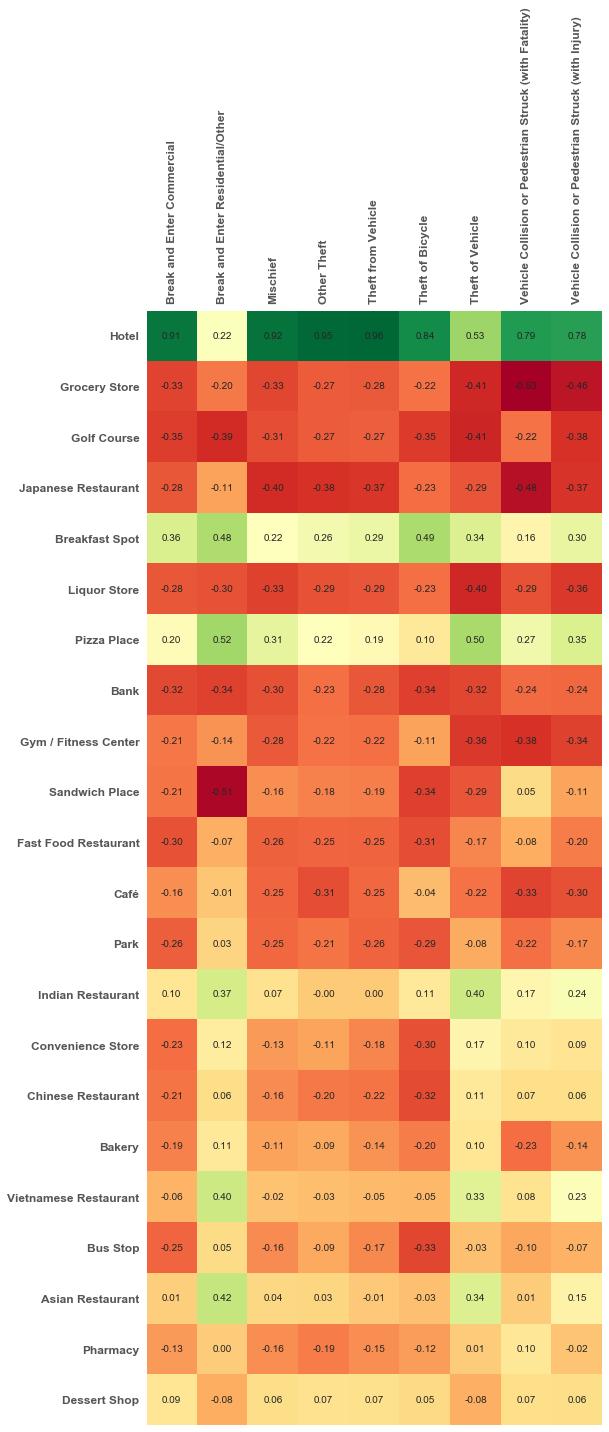

In [44]:
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(111)
ax.imshow(df_corr, cmap=cm.RdYlGn)
ax.set_xticks(np.arange(df_corr.shape[1]))
ax.set_yticks(np.arange(df_corr.shape[0]))
ax.set_xticklabels(df_corr.columns.tolist(), rotation=90, size=12, weight='bold')
ax.xaxis.tick_top()
ax.set_yticklabels(df_corr.index.tolist(), size=12, weight='bold')
# Loop over data dimensions and create text annotations.
for i in np.arange(df_corr.shape[0]):
    for j in np.arange(df_corr.shape[1]):
        text = ax.text(j, i, '{:0.2f}'.format(df_corr.iloc[i, j]),
                       ha='center', va='center')
ax.grid(False)
fig.tight_layout()
plt.savefig('Corr.pdf', bbox_inches='tight')